In [1]:
""" # set parameters for the airborne radar Display
Rmax_Air = 200 #display range, unit: km
Rmin_Air = 0
Bin_length = 150 #unit: m
heading_angle = 30   #set True North as 0 degree,clockwise
range_angle = 90  """
Rmax_Air = 120 #display range, unit: km
Rmin_Air = 0
Bin_length = 150 #unit: m
heading_angle = 295   #set True North as 0 degree,clockwise
range_angle = 90 
# lat lon in rad or in degree
#ll_center=[31.07, 121.0] # central lat lon, that is ,aircraft position
ll_center=[21.6486,112.6397]
file_time = 20220709032400


In [3]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import os
import numpy as np
import webcolors
from osgeo import gdal

from pycwr.io import read_auto
from pycwr.draw.RadarPlot import plot_xy,add_rings
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as colors
import imp

import metpy
from metpy.io import Level3File
import pyart
from pyart.core.transforms import antenna_to_cartesian 
from pyart.core import cartesian_to_geographic
import copy

import pytda
from csu_radartools import csu_fhc

#右下角图例显示的13个色块所表示颜色的编码，可利用MacOS上一colorSLurp的取色器取色
COLORS = [
    '#AD90F0',
    '#9600B4',
    '#FF00F0',
    '#C00001',
    '#D60100',
    '#FF0200',
    '#FF9000',
    '#E7C000',
    '#FEFF00',
    '#009000',
    '#00D800',
    '#00ECEC',
    '#01A0F6'
]

#把颜色的hex码转换为RGB整数值
colors_arrays = np.array([list(webcolors.hex_to_rgb(c)) for c in COLORS])
#print(colors_arrays)
cm_user=np.array(colors_arrays[::-1])/255.0
icmap=colors.ListedColormap(cm_user,name='my_color') 
plt.register_cmap(cmap=icmap)

class Dataset:
    def __init__(self, in_file):
        self.in_file = in_file #Tiff_file
        dataset = gdal.Open(self.in_file)
        self.XSize = dataset.RasterXSize
        self.YSize = dataset.RasterYSize
        self.GeoTransform = dataset.GetGeoTransform()
        self.GetProjection = dataset.GetProjection()
        #self.band1 = dataset.GetRasterBand(1)
    #def get_band(self):
    #    band1 = dataset.GetRasterBand(1)
    #    return band1
    def get_lat_lon(self):
        gtf = self.GeoTransform
        x_range = range(0, self.XSize)
        y_range = range(0, self.YSize)
        x, y = np.meshgrid(x_range, y_range)
        lon = gtf[0] + x*gtf[1] + y*gtf[2]
        lat = gtf[3] + x*gtf[4] + y*gtf[5]
        return lat, lon

def add_ring(ax, azmin,azmax,rings, color="#5B5B5B", linestyle='-', linewidth=0.6, **kwargs):

    theta = np.linspace(azmin, azmax,200)
    
    for i in rings:
        x0 = i * np.cos(theta)
        y0 = i * np.sin(theta)
        gci = ax.plot(x0, y0, linestyle=linestyle, linewidth=linewidth, color=color, **kwargs) # circle
    for rad in np.arange(azmin, azmax+0.01, np.pi / 6.0):
        gci = ax.plot([0, rings[-1] * np.cos(rad)], \
                [0, rings[-1] * np.sin(rad)], \
                linestyle=linestyle, linewidth=linewidth, color=color, **kwargs) #line

def add_line_air(ax, heading_angle,angle_range,rings, color="#5B5B5B", linestyle='-', linewidth=0.6, **kwargs):
    azmin_r = np.deg2rad(heading_angle - 70)
    azmax_r = np.deg2rad(heading_angle + 70 )
    for rad in [azmin_r,azmax_r]:
        print(rad)
        gci = ax.plot([0, rings[-1] * np.cos(rad)], \
            [0, rings[-1] * np.sin(rad)], \
            linestyle=linestyle, linewidth=linewidth+1, color=color, **kwargs) #line

def rotate(x,y,alpha):
    #假设对图片上任意点(x,y)，绕一个坐标点(rx0,ry0)逆时针旋转a角度后的新的坐标设为(x0, y0)，有公式：
    # x0= (x - rx0)*cos(a) - (y - ry0)*sin(a) + rx0 ;
    # y0= (x - rx0)*sin(a) + (y - ry0)*cos(a) + ry0 ;
    alpha = np.deg2rad(alpha)
    x_r = x * np.cos(alpha) - y *np.sin(alpha)
    y_r = x * np.sin(alpha) + y *np.cos(alpha)
    return x_r, y_r

def get_z_from_radar(radar):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = antenna_to_cartesian(sr_2d/1000.0, az_2d, el_2d)
    return zz + radar.altitude['data']

def check_sounding_for_montonic(sounding_df):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = sounding_df['temperature'].values  # In old SkewT, was sounding.data
    snd_z = sounding_df['height'].values  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    #if not snd_T.mask[0]:  # May cause issue for specific soundings
    dummy_z.append(snd_z[0])
    dummy_T.append(snd_T[0])
    for i, height in enumerate(snd_z):
        if i > 0:
            if snd_z[i] > snd_z[i-1]: #and not snd_T.mask[i]
                dummy_z.append(snd_z[i])
                dummy_T.append(snd_T[i])
    snd_z = np.array(dummy_z)
    snd_T = np.array(dummy_T)
    return snd_T, snd_z


def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()
    rad_T1d = np.interp(rad_z1d, snd_z, snd_T)
    return np.reshape(rad_T1d, shape), radar_z
    return x_r, y_r


def plot_list_of_fields(radar, sweep=0, fields=['reflectivity'], vmins=[0],
                        vmaxs=[65], units=['dBZ'], cmaps=['RdYlBu_r'],
                        return_flag=False, xlim=[-150, 150], ylim=[-150, 150],
                        mask_tuple=None):
    num_fields = len(fields)
    if mask_tuple is None:
        mask_tuple = []
        for i in np.arange(num_fields):
            mask_tuple.append(None)
    nrows = (num_fields + 1) // 2
    ncols = (num_fields + 1) % 2 + 1
    fig = plt.figure(figsize=(14.0, float(nrows)*5.5))
    display = pyart.graph.RadarDisplay(radar)
    for index, field in enumerate(fields):
        ax = fig.add_subplot(nrows, 2, index+1)
        display.plot_ppi(field, sweep=sweep, vmin=vmins[index],
                         vmax=vmaxs[index],
                         colorbar_label=units[index], cmap=cmaps[index],
                         mask_tuple=mask_tuple[index])
        display.set_limits(xlim=xlim, ylim=ylim)
        
    plt.tight_layout()
    if return_flag:
        return display

print(os.getcwd())

/var/folders/8p/1s_25tdx2nxc6ffrjn_stzsm0000gn/T/ipykernel_60331/2228813926.py:15: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

/Users/xiaowu/Library/Mobile Documents/com~apple~CloudDocs/work/MeteoDataFusion


/Users/xiaowu/opt/anaconda3/lib/python3.8/site-packages/pyart/graph/cm.py:139: UserWarning: Trying to register the cmap 'pyart_NWSRef' which already exists.
  mpl.colormaps.register(name=full_name, cmap=cmap, force=True)
/Users/xiaowu/opt/anaconda3/lib/python3.8/site-packages/pyart/graph/cm.py:139: UserWarning: Trying to register the cmap 'pyart_NWSVel' which already exists.
  mpl.colormaps.register(name=full_name, cmap=cmap, force=True)
/Users/xiaowu/opt/anaconda3/lib/python3.8/site-packages/pyart/graph/cm.py:139: UserWarning: Trying to register the cmap 'pyart_NWS_SPW' which already exists.
  mpl.colormaps.register(name=full_name, cmap=cmap, force=True)
/Users/xiaowu/opt/anaconda3/lib/python3.8/site-packages/pyart/graph/cm.py:139: UserWarning: Trying to register the cmap 'pyart_RefDiff' which already exists.
  mpl.colormaps.register(name=full_name, cmap=cmap, force=True)
/Users/xiaowu/opt/anaconda3/lib/python3.8/site-packages/pyart/graph/cm.py:139: UserWarning: Trying to register the

In [2]:
#sounding
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']
df = pd.read_fwf('1115Z_20220425.txt',
                 skiprows=6, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Drop any rows with all NaN values for T, Td, winds
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
                       ), how='all').reset_index(drop=True)

# We will pull the data out of the example dataset into individual variables and
# assign units.
height = df['height'].values * units.meter
p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
#print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
#print(parcel_prof)
cape, cin = mpcalc.cape_cin(p, T, Td, parcel_profile=parcel_prof, which_lfc='bottom',which_el='top')
print(cape, cin)

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


183.97428594645137 joule / kilogram -160.56853873059725 joule / kilogram


/Users/xiaowu/opt/anaconda3/lib/python3.8/site-packages/pycwr/core/NRadar.py:165: RuntimeWarning: All-NaN slice encountered
  GridV = get_CR_xy(vol_azimuth, vol_range, fix_elevation, vol_value,\


<xarray.Dataset>
Dimensions:       (x_cr: 321, y_cr: 321, x_cappi_3000: 321, y_cappi_3000: 321)
Coordinates:
  * x_cr          (x_cr) int64 -160000 -159000 -158000 ... 158000 159000 160000
  * y_cr          (y_cr) int64 -160000 -159000 -158000 ... 158000 159000 160000
  * x_cappi_3000  (x_cappi_3000) int64 -160000 -159000 -158000 ... 159000 160000
  * y_cappi_3000  (y_cappi_3000) int64 -160000 -159000 -158000 ... 159000 160000
Data variables:
    CR            (x_cr, y_cr) float64 9.486 10.89 12.92 ... 26.47 19.56 11.5
    CAPPI_3000    (x_cappi_3000, y_cappi_3000) float64 nan nan nan ... nan nan


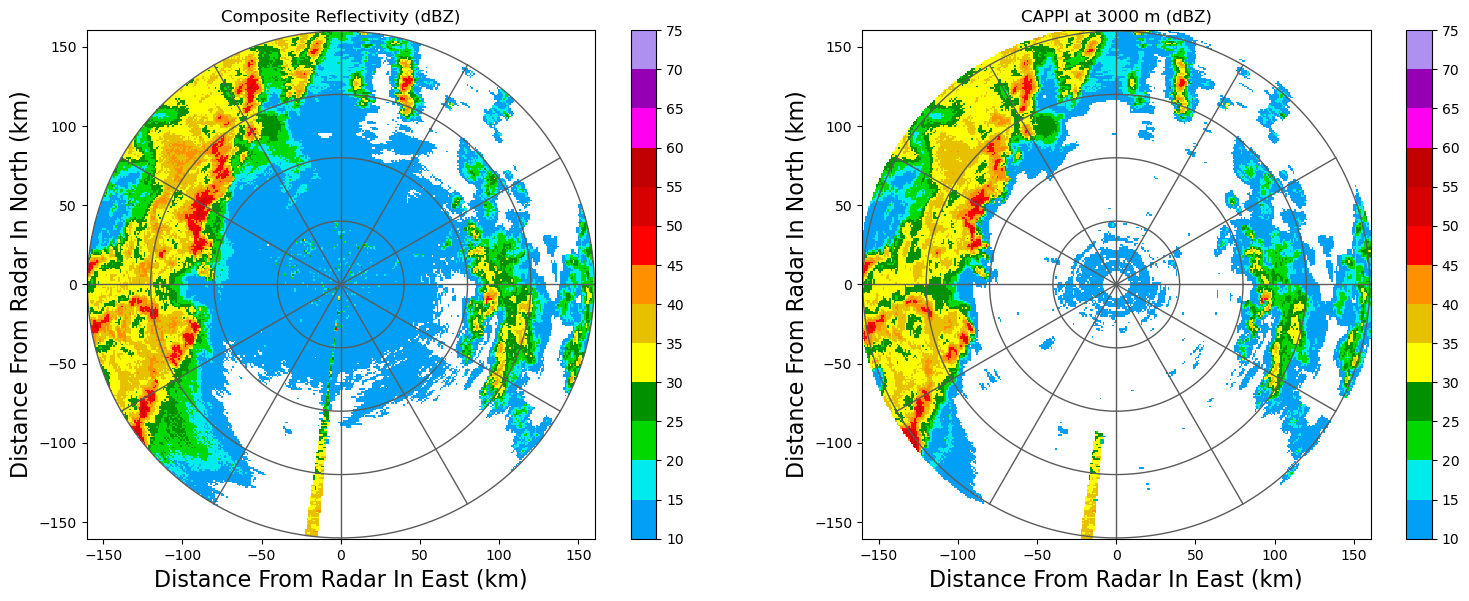

In [4]:
#98D radar for verify

path = '/Users/xiaowu/Library/Mobile Documents/com~apple~CloudDocs/work/MeteoDataFusion'
infile = os.path.join(path,'test','data','Z9002.20220425.060745.AR2.bz2')
PRD = read_auto(infile)

x1d = np.arange(-160000, 160001, 1000) ##x方向1km等间距， -150km～150km范围
y1d = np.arange(-160000, 160001, 1000) ##y方向1km等间距， -150km～150km范围
PRD.add_product_CR_xy(XRange=x1d, YRange=y1d)
PRD.add_product_CAPPI_xy(XRange=x1d, YRange=y1d, level_height= 3000)
print(PRD.product)
grid_x, grid_y = np.meshgrid(x1d, y1d, indexing="ij")

CompRef = np.zeros((len(x1d),len(y1d)),dtype=float)

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
for i in np.arange(0,len(x1d)):
    for j in np.arange(0,len(y1d)):
        if ((x1d[i]/1000)**2+(y1d[j]/1000)**2 )<160**2:
            CompRef[i][j] = PRD.product['CR'][i][j]
        else:
            CompRef[i][j] = np.nan
    
#CompRef = np.where( (i**2+y1d**2<160000**2),PRD.product['CR'],np.nan)
plot_xy(ax1, grid_x, grid_y, CompRef,bounds=np.arange(10, 76, 5),cmap=icmap) ##画图显示 
add_rings(ax1, [0, 40, 80, 120, 160], color="#5B5B5B", linestyle='-', linewidth=1)
ax1.set_xlabel("Distance From Radar In East (km)", fontsize=16)
ax1.set_ylabel("Distance From Radar In North (km)", fontsize=16)
ax1.set_title("Composite Reflectivity (dBZ)") #  at %s" %)

ax2 = fig.add_subplot(1,2,2)
plot_xy(ax2, grid_x, grid_y, PRD.product.CAPPI_3000,bounds=np.arange(10, 76, 5),cmap=icmap) ##画图显示
add_rings(ax2,[0, 40, 80, 120, 160], color="#5B5B5B", linestyle='-', linewidth=1)
ax2.set_xlabel("Distance From Radar In East (km)", fontsize=16)
ax2.set_ylabel("Distance From Radar In North (km)", fontsize=16)
ax2.set_title("CAPPI at 3000 m (dBZ)")

plt.tight_layout()

str_="verify"
plt.savefig(r"%s.png"%str_, dpi=600)

<xarray.Dataset>
Dimensions:            (sweep: 9)
Coordinates:
  * sweep              (sweep) int64 0 1 2 3 4 5 6 7 8
Data variables:
    latitude           float64 31.07
    longitude          float64 121.0
    altitude           int64 39
    scan_type          <U3 'ppi'
    frequency          float64 2.83
    start_time         datetime64[ns] 2022-04-25T06:08:18.678857
    end_time           datetime64[ns] 2022-04-25T06:12:59.436845
    nyquist_velocity   (sweep) float32 26.85 26.85 26.85 ... 31.27 31.27 31.27
    unambiguous_range  (sweep) int32 230000 230000 230000 ... 124000 124000
    rays_per_sweep     (sweep) int64 360 360 364 362 362 361 364 364 364
    fixed_angle        (sweep) float32 0.4834 1.494 2.417 ... 9.888 14.59 19.51
    beam_width         (sweep) float64 1.0 1.0 0.989 ... 0.989 0.989 0.989
velocity
spectrum_width
total_power
reflectivity
differential_reflectivity
cross_correlation_ratio
differential_phase
specific_differential_phase
horizontal_signal_noise_ratio


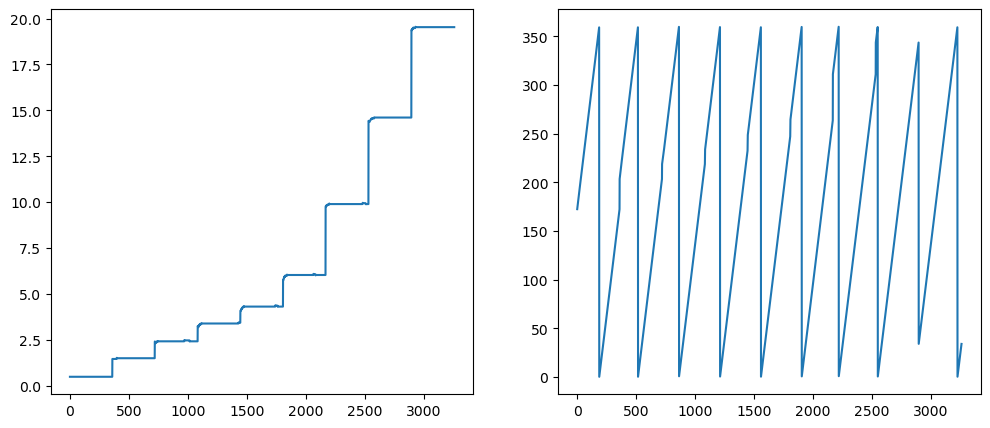

In [5]:
print(PRD.scan_info)
#print(PRD.fields)

#转为Pyart格式
PyartRadar = PRD.ToPyartRadar()
for field_name in PyartRadar.fields.keys():
    print(field_name)

sweep_slice = PyartRadar.get_slice(2)

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax1.plot(PyartRadar.elevation['data'])
ax1 = fig.add_subplot(122)
ax1.plot(PyartRadar.azimuth['data'])

In [23]:
print(PyartRadar.get_slice(2))
PyartRadar.fields['reflectivity']['data'][PyartRadar.get_slice(1)].shape
PyartRadar.fields['reflectivity']['data'][PyartRadar.get_slice(1)].max()


slice(720, 1084, None)


61.5

In [5]:
print(PyartRadar.azimuth.keys())
print(PyartRadar.azimuth['long_name'])
print(PyartRadar.azimuth['comment']) #clockwise

dict_keys(['units', 'standard_name', 'long_name', 'axis', 'comment', 'data'])
azimuth_angle_from_true_north
Azimuth of antenna relative to true north


c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


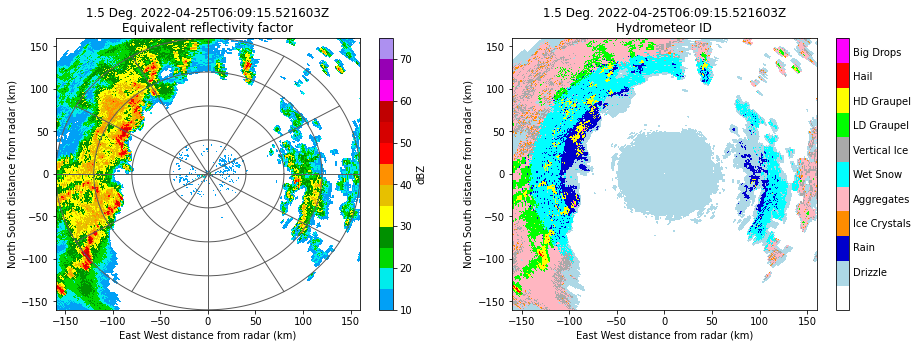

In [6]:
#PyartRadar.fields['FH']['data'][sweep_slice]
#HCA 
def two_panel_plot(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65, cmap1='RdYlBu_r', 
                   units1='dBZ', var2='differential_reflectivity', vmin2=-5, vmax2=5, 
                   cmap2='RdYlBu_r', units2='dB', return_flag=False, xlim=[-150,150],
                   ylim=[-150,150]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121)
    display.plot_ppi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_ppi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display

hid_colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
              'Cyan', 'DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphid = colors.ListedColormap(hid_colors)

hid4_colors = ['White', 'MediumBlue', 'Cyan', 'LightPink', 'Red']
cmaphid4 = colors.ListedColormap(hid4_colors)

cmapmeth = colors.ListedColormap(hid_colors[0:6])

def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 10, 0.9))
    cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                           'Wet Snow', 'Vertical Ice', 'LD Graupel',
                           'HD Graupel', 'Hail', 'Big Drops'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='reflectivity'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    masked_field = np.ma.asanyarray(field)
    fill_value = -32768
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', radar.fields[dz_field]['data'].mask)
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar


dz = PyartRadar.fields['reflectivity']['data']
dr = PyartRadar.fields['differential_reflectivity']['data']
kd = PyartRadar.fields['specific_differential_phase']['data']
rh = PyartRadar.fields['cross_correlation_ratio']['data']

radar_T, radar_z = interpolate_sounding_to_radar(df, PyartRadar)
fh = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True, band='S',
                                T=radar_T)
PyartRadar = add_field_to_radar_object(fh, PyartRadar)
# Actual plotting done here
lim = [-160, 160]
fig, ax1, ax2, display = two_panel_plot(PyartRadar, sweep=1, vmin1=10, vmax1=75, var1='reflectivity', cmap1=icmap, var2='FH', vmin2=0, 
                                        vmax2=10, cmap2=cmaphid, units2='', return_flag=True, 
                                        xlim=lim, ylim=lim)

add_rings(ax1,[0, 40, 80, 120, 160], color="#5B5B5B", linestyle='-', linewidth=1)
display.cbs[1] = adjust_fhc_colorbar_for_pyart(display.cbs[1])
plt.savefig('hid.png')

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3261, 1320)
(3261, 1320)


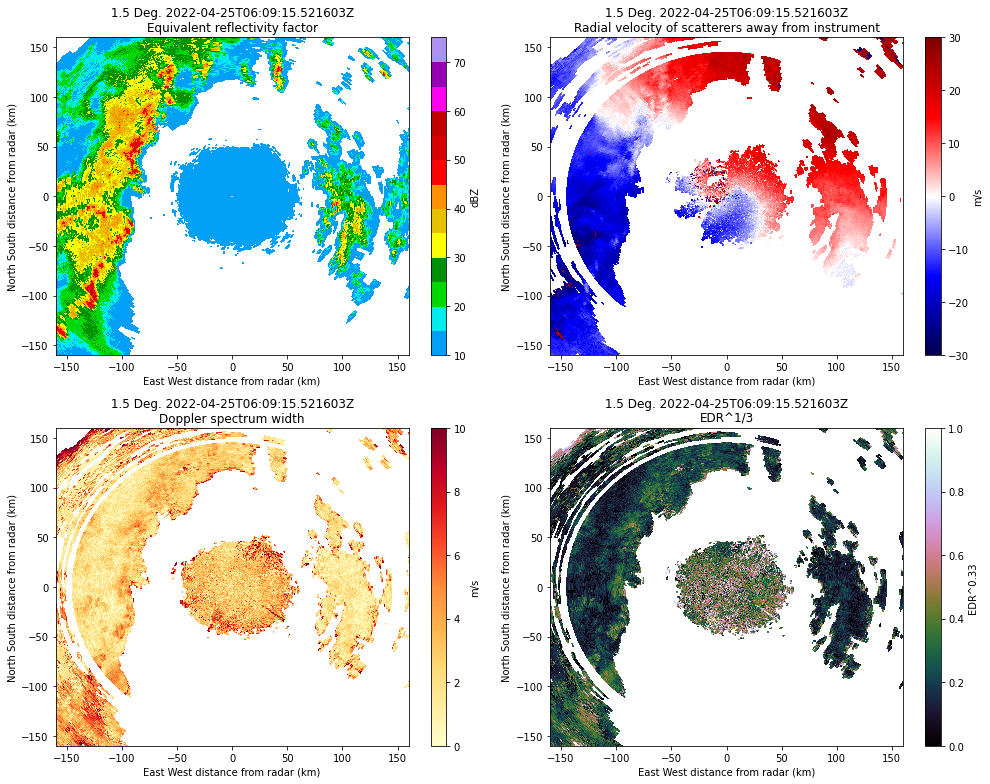

In [7]:
# Turbulence calculation and Display
pytda.calc_turb_vol(PyartRadar, name_sw='spectrum_width', name_dz='reflectivity', verbose=False,
                    gate_spacing=250.0/1000.0, use_ntda=False)
print(PyartRadar.fields['turbulence']['data'].shape)
print(PyartRadar.fields['FH']['data'].shape)
x_98d, y_98d = display._get_x_y(sweep =1, edges = False, filter_transitions = True) 

turb_data = PyartRadar.fields['turbulence']['data'][sweep_slice]
hid_data = PyartRadar.fields['FH']['data'][sweep_slice]

plot_list_of_fields(PyartRadar, sweep=1, xlim=[-160, 160], ylim=[-160, 160],
                    fields=['reflectivity', 'velocity', 'spectrum_width', 'turbulence'],
                    vmins=[10, -30, 0, 0], vmaxs=[75, 30, 10, 1.0], 
                    units=['dBZ', 'm/s', 'm/s', 'EDR^0.33'],
                    cmaps=[icmap, 'seismic', 'YlOrRd', 'cubehelix'])

plt.savefig('turb.png')            

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[70 65 60 55 50 45 40 35 30 25 20 15 10]


' plt.imshow(dBZ_figure,cmap=icmap,vmin = vmin, vmax = vmax)\nplt.colorbar() '

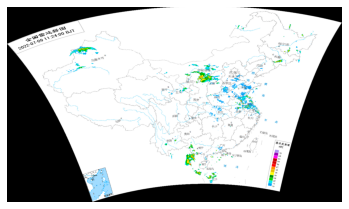

In [8]:
from osgeo import gdal
#获取图例的像素位置区域范围
left_x = 955
upper_y = 665
right_x = 973
lower_y = 858

ds = gdal.Open("dbz_new_ll.tiff")
dataset = Dataset("dbz_new_ll.tiff")
lat, lon = dataset.get_lat_lon() #每个格点的经纬度信息
rbg_value = np.stack([ds.GetRasterBand(i).ReadAsArray() for i in (1,2,3)]) #每个格点的RGB信息
plt.imshow(np.transpose(rbg_value,(1,2,0))) 
plt.axis("off")
#plt.savefig('present.png')

min_max = [10, 70] 
vmin, vmax = min_max
dBZ_levels = np.arange(70, 5, -5)
print(dBZ_levels)
dBZ_figure = np.empty(shape=(rbg_value.shape[1],rbg_value.shape[2]))
for n, colors_array in enumerate(colors_arrays):
    dist = np.sum( (np.transpose(rbg_value,(1,2,0)) - colors_array)**2, axis = 2 )
    dbz_index = np.where( (dist == dist.min()) & (dist.min()< 10) )
    #print(dist.min())
    dBZ_figure[dbz_index] = dBZ_levels[n]-0.1 

dBZ_figure = np.where(dBZ_figure == 0.0, np.nan , dBZ_figure)
""" plt.imshow(dBZ_figure,cmap=icmap,vmin = vmin, vmax = vmax)
plt.colorbar() """

In [9]:
def add_ring_China(ax, ll_ac,lat, lon, azmin,azmax,rings, color="#5B5B5B", linestyle='-', linewidth=0.6, **kwargs):
    #add_ring(ax1, 0,np.pi, [0, 40, 80, 120, 160], linestyle='-', linewidth=1)
    #print("min")
    #print(azmin,azmax)
    theta = np.linspace(azmin, azmax,200)
    
    for i in rings:
        for az in theta: 
            lllat = i *  np.sin(az)/111.0 + ll_ac[0] 
            lllon = np.rad2deg(i * np.cos(az) /(R_earth * np.cos(np.deg2rad(lllat)))) + ll_ac[1]
            y0, x0 = np.where( (np.abs(lat - lllat) < 0.04)  & (np.abs(lon - lllon) < 0.04))
            #print(x0,y0)
            gci = ax.plot(x0[0], y0[0], linestyle=linestyle, linewidth=linewidth, color=color, **kwargs) # circle

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
def rotate_x0y0(x,y,x0,y0,alpha):
    #假设对图片上任意点(x,y)，绕一个坐标点(rx0,ry0)逆时针旋转a角度后的新的坐标设为(x0, y0)，有公式：
    # x0= (x - rx0)*cos(a) - (y - ry0)*sin(a) + rx0 ;
    # y0= (x - rx0)*sin(a) + (y - ry0)*cos(a) + ry0 ;
    alpha = np.deg2rad(alpha)
    x_r = (x-x0) * np.cos(alpha) - (y-y0) *np.sin(alpha)
    y_r = (x-x0) * np.sin(alpha) + (y-y0) *np.cos(alpha)
    return x_r, y_r

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
        lat_grid = y / 1000.0 /111.0 + ll_center[0]
        lon_grid = np.rad2deg(x / 1000.0 /(R_earth * np.cos(np.deg2rad(lat_grid)))) + ll_center[1]

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'y' is not defined

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


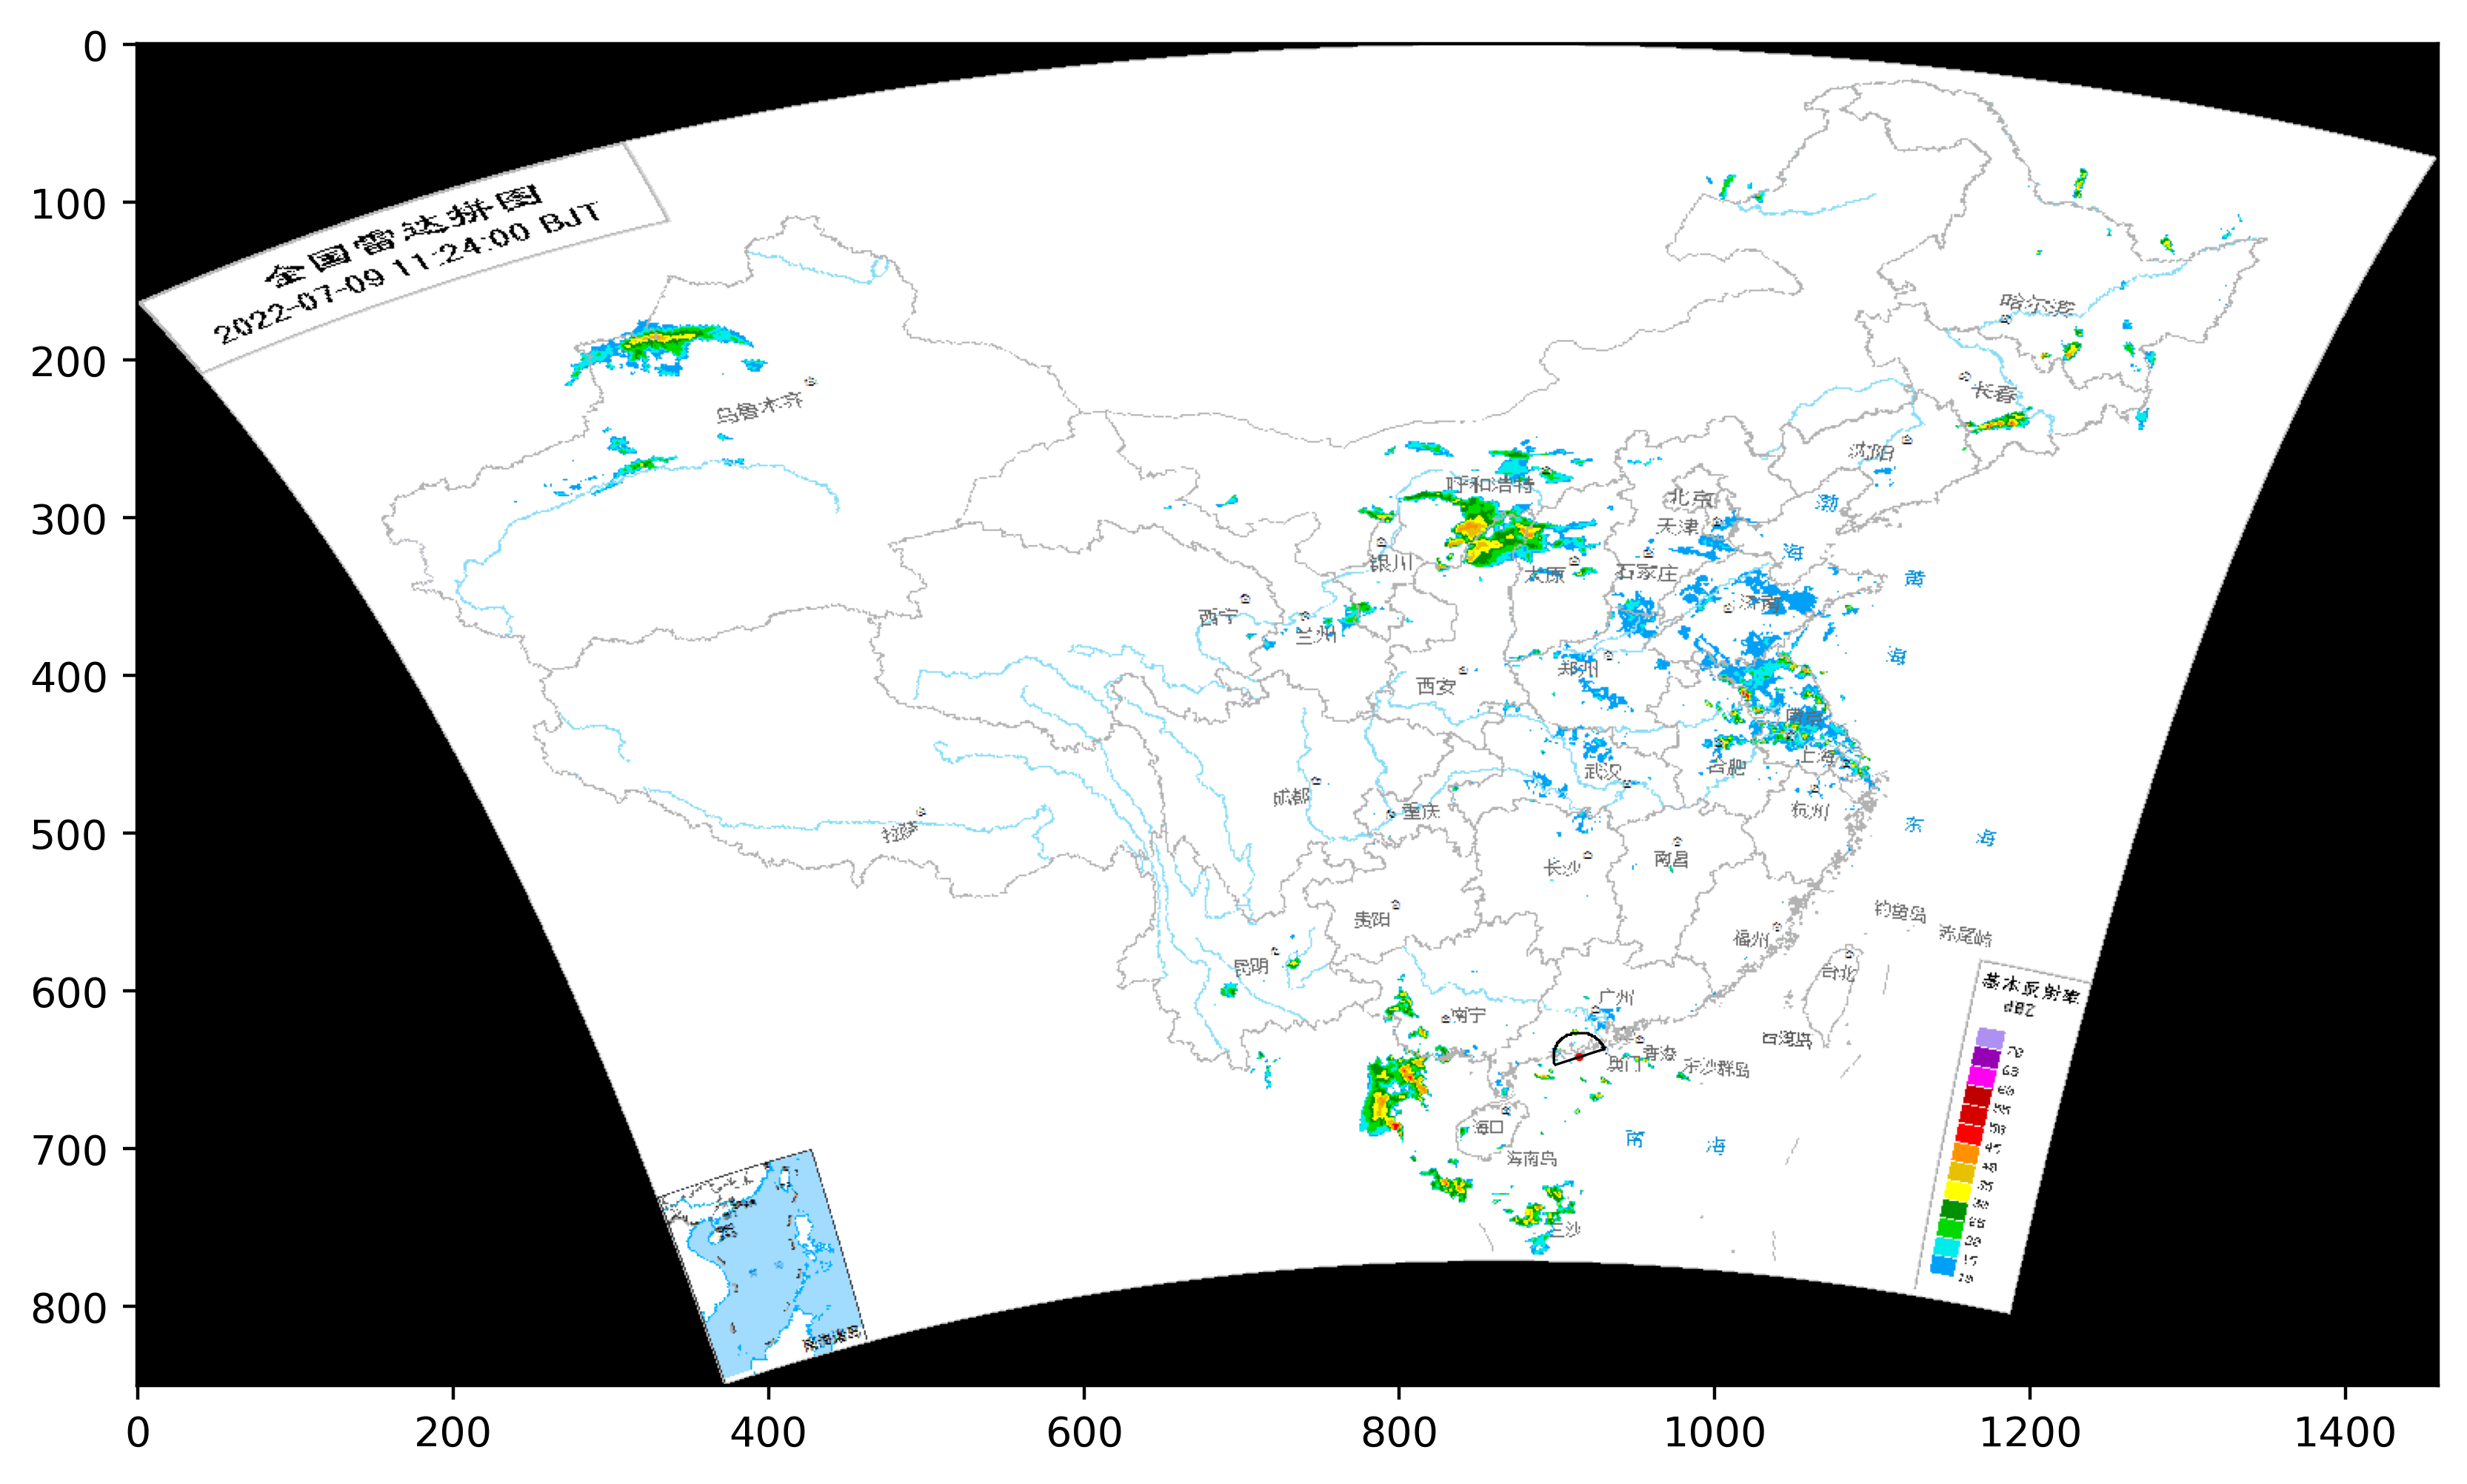

In [ ]:
fig = plt.figure(figsize=(12, 6),dpi = 400)
ax = fig.add_subplot(111)

plt.imshow(np.uint8(np.transpose(rbg_value,(1,2,0))))
yy, xx = np.where( ( np.abs(lat - ll_center[0]) < 0.04 )  & ( np.abs(lon - ll_center[1]) < 0.04 ) )
#xx, yy = np.argmin( (lat - ll_center[0])**2 + (lon - ll_center[1]) **2 )
ax.scatter(xx[0], yy[0], s = 1, color = 'red')
axe = plt.gca()
#add_ring_China(ax=axe, ll_ac = ll_center, lat = lat, lon = lon, azmin = 0, azmax = np.pi, rings=[40, 80] )


theta = np.linspace(-np.pi/2+heading_angle, np.pi/2+heading_angle, 200)
x_list = []
y_list = []


for az in theta: 
    lllat = 88*  np.cos(az)/111.0 + ll_center[0]  #y = 80 * sin(az)
    lllon = np.rad2deg(88 * np.sin(az) /(R_earth * np.cos(np.deg2rad(lllat)))) + ll_center[1]
    y0, x0 = np.where( (np.abs(lat - lllat) < 0.04)  & (np.abs(lon - lllon) < 0.04))
    x_list.append(x0[0])
    y_list.append(y0[0])

#X1,Y1 = rotate_x0y0(x_list, y_list, xx[0], yy[0], heading_angle)


ax.plot(x_list, y_list, color='black', linewidth = 0.6) # circle
ax.plot([x_list[0],x_list[-1]], [y_list[0],y_list[-1]], y_list, color='black', linewidth = 0.6) # line
plt.savefig('testtest.png')

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2265: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if v not in values:


ValueError: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8) is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'CN_hcl', 'CN_ref', 'CN_vel', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'my_color', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'pyart_BlueBrown10', 'pyart_BlueBrown10_r', 'pyart_BlueBrown11', 'pyart_BlueBrown11_r', 'pyart_BrBu10', 'pyart_BrBu10_r', 'pyart_BrBu12', 'pyart_BrBu12_r', 'pyart_Bu10', 'pyart_Bu10_r', 'pyart_Bu7', 'pyart_Bu7_r', 'pyart_BuDOr12', 'pyart_BuDOr12_r', 'pyart_BuDOr18', 'pyart_BuDOr18_r', 'pyart_BuDRd12', 'pyart_BuDRd12_r', 'pyart_BuDRd18', 'pyart_BuDRd18_r', 'pyart_BuGr14', 'pyart_BuGr14_r', 'pyart_BuGy8', 'pyart_BuGy8_r', 'pyart_BuOr10', 'pyart_BuOr10_r', 'pyart_BuOr12', 'pyart_BuOr12_r', 'pyart_BuOr8', 'pyart_BuOr8_r', 'pyart_BuOrR14', 'pyart_BuOrR14_r', 'pyart_Carbone11', 'pyart_Carbone11_r', 'pyart_Carbone17', 'pyart_Carbone17_r', 'pyart_Carbone42', 'pyart_Carbone42_r', 'pyart_Cat12', 'pyart_Cat12_r', 'pyart_EWilson17', 'pyart_EWilson17_r', 'pyart_GrMg16', 'pyart_GrMg16_r', 'pyart_Gray5', 'pyart_Gray5_r', 'pyart_Gray9', 'pyart_Gray9_r', 'pyart_HomeyerRainbow', 'pyart_HomeyerRainbow_r', 'pyart_LangRainbow12', 'pyart_LangRainbow12_r', 'pyart_NWSRef', 'pyart_NWSRef_r', 'pyart_NWSVel', 'pyart_NWSVel_r', 'pyart_NWS_SPW', 'pyart_NWS_SPW_r', 'pyart_PD17', 'pyart_PD17_r', 'pyart_RRate11', 'pyart_RRate11_r', 'pyart_RdYlBu11b', 'pyart_RdYlBu11b_r', 'pyart_RefDiff', 'pyart_RefDiff_r', 'pyart_SCook18', 'pyart_SCook18_r', 'pyart_StepSeq25', 'pyart_StepSeq25_r', 'pyart_SymGray12', 'pyart_SymGray12_r', 'pyart_Theodore16', 'pyart_Theodore16_r', 'pyart_Wild25', 'pyart_Wild25_r', 'pyart_balance', 'pyart_balance_r', 'pyart_ref_r', 'pyart_vel_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

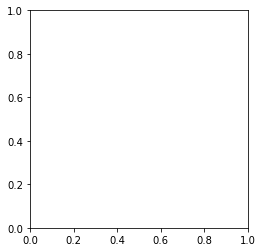

In [ ]:
#加载图片文件
path='E:/xiaowu/空天地//'
raw_img_array = plt.imread(path+'Z_RADA_C_BABJ_20220425061200_P_DOR_RDCP_R_ACHN.PNG')
#0-255整数形式的RGB数值更为精确和通用，plt.imread读取的颜色为0-1的浮点数，因此转换为int型
rgb_img_array = (raw_img_array * 255).astype(int)
plt.imshow("testttt.png",np.uint8(raw_img_array))

In [ ]:
# Convert to the aircraft-centered grids
import math
# lat lon in rad or in degree
ll_center=[31.07, 121.0] # central lat lon, that is ,aircraft position
R_earth = 6371.393
dist_y = (lat - ll_center[0])*111.0 # unit: km
dist_x = np.deg2rad((lon - ll_center[1])) * R_earth * np.cos(np.deg2rad(lat)) # for np.arrays, * is for element-wise product

R_grid = np.sqrt(dist_y * dist_y + dist_x * dist_x)
# get the azimuth from 0 to 360 from east
Az_grid = np.abs(np.arctan(dist_y / dist_x) * 180 / math.pi)
Az_grid = np.where( (dist_x < 0) & ( dist_y > 0), 180 - Az_grid, Az_grid)
Az_grid = np.where( (dist_x < 0) & ( dist_y < 0), 180 + Az_grid, Az_grid)
Az_grid = np.where( (dist_x > 0) & ( dist_y < 0), 360 - Az_grid, Az_grid)
print(Az_grid.max(),Az_grid.min())

ngate = int(np.round( (Rmax_Air-Rmin_Air) * 1000 / Bin_length ))
Azmin = heading_angle  - range_angle #+ 90
Azmax = heading_angle  + range_angle #+ 90

def AngleToValid(angle):
    ans = angle - int(np.floor_divide(angle, 360.0)) * 360
    return ans
""" if  Azmin < 0: 
    Az_range = np.arange(Azmin,0) + np.arange(0,Azmax)
elif Azmax > 360:
    Az_range = np.arange(Azmin,360) + np.arange(0,AngleToValid(Azmax))
else:
    Az_range = np.arange(Azmin,Azmax)+ """


""" if (heading_angle + 90 + range_angle < 360):
    Azmin = heading_angle + 90 - range_angle
    Azmax = heading_angle + 90 + range_angle
elif (heading_angle + 90 + range_angle > 360): """
#dAz = 1
#Beam_Width = 4
#turb_data = PyartRadar.fields['turbulence']['data'][sweep_slice]

# Calculate the coverage of the radial beam of the current carrier in polar coordinate
dbz_ac = np.zeros((360, ngate))
turb_ac = np.zeros((360, ngate))
hid_ac = np.zeros((360, ngate))
longtitude = np.zeros((360, ngate))
latitude = np.zeros((360, ngate))
mask_Z = np.zeros((dBZ_figure.shape[0],dBZ_figure.shape[1]))
radarX = np.zeros((360, ngate))
radarY = np.zeros((360, ngate))
""" dbz_ac = np.zeros((Azmax, ngate))
turb_ac = np.zeros((Azmax, ngate))
hid_ac = np.zeros((Azmax, ngate))
longtitude = np.zeros((Azmax, ngate))
latitude = np.zeros((Azmax, ngate))
mask_Z = np.zeros((dBZ_figure.shape[0],dBZ_figure.shape[1]))
radarX = np.zeros((Azmax, ngate)) 
radarY = np.zeros((Azmax, ngate))"""
for i_az in np.arange(Azmin, Azmax+1): #azimuth comes from east, the direction is counterclockwise
    for i_bin in np.arange(0, ngate):
        i_az_valied = int(AngleToValid(i_az))

        #R_ac = np.array([( i_bin -1 ) * Bin_length, i_bin * Bin_length])
        #Az_ac = np.array([ i_az - Beam_Width/2, i_az + Beam_Width/2])
        #xy_center = np.array( i_bin * Bin_length * [ np.cos( i_az * math.pi / 180), np.sin( i_az * math.pi / 180) ])
        #x0 = R_ac * np.cos( Az_ac * math.pi / 180)
        x = i_bin * Bin_length * np.sin(np.deg2rad(i_az))
        y = i_bin * Bin_length * np.cos(np.deg2rad(i_az))
        #radarX.append(x)
        #radarY.append(y)
        radarX[i_az_valied, i_bin]  = x
        radarY[i_az_valied, i_bin]  = y

        #dist_y = (lat - ll_center[0])*111.0 # unit: km
        #dist_x = np.deg2rad((lon - ll_center[1])) * R_earth * np.cos(np.deg2rad(lat))

        lat_grid = y / 1000.0 /111.0 + ll_center[0]
        lon_grid = np.rad2deg(x / 1000.0 /(R_earth * np.cos(np.deg2rad(lat_grid)))) + ll_center[1]
        y_index = np.argmin(np.abs(lat[:, 10] - lat_grid)) #10 is a random number, 因为是等经纬度投影
        x_index = np.argmin(np.abs(lon[10, :] - lon_grid))
        
        turb_use = 0
        if (turb_use > 0):
            if i_bin * Bin_length/ 1000.0 > 50:
                az_index = np.argmin(np.abs(i_az_valied - PyartRadar.azimuth['data'][sweep_slice]))
                ra_index = np.argmin(np.abs(i_bin * Bin_length - PyartRadar.range['data']))
                #print(az_index, ra_index, i_az, i_bin, i_bin * Bin_length)
                turb_ac[i_az_valied, i_bin] = turb_data[az_index,ra_index]
                hid_ac[i_az_valied, i_bin] = hid_data[az_index,ra_index]
            else: 
                turb_ac[i_az_valied, i_bin] = np.nan
                hid_ac[i_az_valied, i_bin] = np.nan

        dbz_ac[i_az_valied, i_bin] = dBZ_figure[y_index, x_index] 
        longtitude[i_az_valied, i_bin]  = lon_grid
        latitude[i_az_valied, i_bin]    = lat_grid
        
        mask_Z[y_index, x_index] = 1

dBZ_levels = np.arange(70, 5, -5)
print('test')
#longtitude默认是0,应该是缺测
print(np.nanmax(longtitude), np.nanmin(longtitude))
print(latitude.max(), latitude.min())
longtitude = np.where(longtitude == 0.0, np.nan, longtitude)
latitude = np.where(latitude == 0.0, np.nan, latitude)
print(np.nanmax(longtitude), np.nanmin(longtitude))
print(np.nanmax(dbz_ac),np.nanmin(dbz_ac))

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


359.92759260104236 0.10266585991183344
test
121.53738347320059 0.0
32.14972972972973 0.0
121.53738347320059 119.74165456782346
39.9 0.0


c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-10-5c30daf68c0d>:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax1.pcolormesh( X1/1000, Y1/1000, dbz_ac, shading='auto', vmin = vmin, vmax = vmax, cmap=icmap ) #zorder=0,  dbz_ac是跟着转的，因为某个点对应的X1，Y1和dbz_ac是固定的
<ipython-input-10-5c30daf68c0d>:19: RuntimeWarning: invalid value encountered in greater
  turb_index = np.argwhere(turb_ac > 0.7)


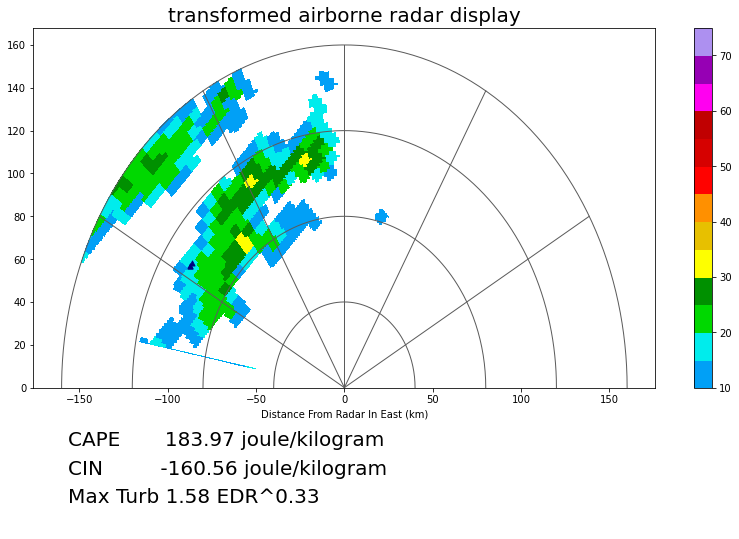

In [ ]:
fig = plt.figure(figsize=(12,10))
#fig, ax = plt.subplots()
#assert isinstance(ax, matplotlibs.axes._axes.Axes)

#否则会画出很多蓝色
dbz_ac = np.where(dbz_ac == 0.0, np.nan , dbz_ac)


levels = MaxNLocator(nbins=13).tick_values(vmin, vmax)
ticks = levels
#pc = ax.pcolormesh( longtitude, latitude, dbz_ac,zorder=0, shading='auto') #,cmap='plasma'
#ax1 = fig.add_subplot(2,1,1)
ax1 = fig.add_axes([0.1, 0.3, 0.9, 0.5]) # [left, bottom, width, height]  ,facecolor='black'
X1,Y1 = rotate(radarX, radarY, heading_angle) # rotate should be clockwise --> *-1
pc = ax1.pcolormesh( X1/1000, Y1/1000, dbz_ac, shading='auto', vmin = vmin, vmax = vmax, cmap=icmap ) #zorder=0,  dbz_ac是跟着转的，因为某个点对应的X1，Y1和dbz_ac是固定的

hail_index = np.argwhere(hid_ac == 9)
#hail_index = np.concatenate( (np.argwhere(hid_ac == 9) ,  np.argwhere(hid_ac == 8)) )
turb_index = np.argwhere(turb_ac > 0.7) 
""" print(hail_index)
print(hail_index.shape) #50, 2
print(hail_index[0]) #[233 1046]
print(X1.shape) #(360, 1067)
print(X1[233,1046]/1000) 
#print(hail_index[:,0]) 
#print(hail_index[:,1]) 
print(X1[hail_index[:,0],hail_index[:,1]]/1000) 
 """
pc1 = ax1.scatter(X1[hail_index[:,0],hail_index[:,1]]/1000, Y1[hail_index[:,0],hail_index[:,1]]/1000, marker = '*', color = 'magenta', s=25)

#pc1 = ax1.pcolormesh( X1/1000, Y1/1000, hid_ac, vmin = 0, vmax = 10, cmap=cmaphid )
pc1 = ax1.scatter( X1[turb_index[:,0],turb_index[:,1]]/1000, Y1[turb_index[:,0],turb_index[:,1]]/1000, marker = '^', color = 'navy', s=25)

#pc2 =  ax1.contour(
#             X1/1000, Y1/1000, turb_ac, vmin=0.4, vmax=0.8, levels=np.array([0.6,0.8]), colors = 'black') #cmap='YlOrRd')  #, levels=np.array([0.4,0.6,0.8]


""" cb.set_ticks(np.arange(1.4, 10, 0.9))
    cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                           'Wet Snow', 'Vertical Ice', 'LD Graupel',
                           'HD Graupel', 'Hail', 'Big Drops'])
 """
#ax1.contourf(X1/1000, Y1/1000, PyartRadar.fields['turbulence']['data'], vmin=0.4, vmax=0.8) [sweep_slice]
add_ring(ax1, 0,np.pi, [0, 40, 80, 120, 160], linestyle='-', linewidth=1)
#ax1.text()
#plot_xy(ax1, radarX, radarY, dbz_ac) ##画图显示
ax1.set_title('transformed airborne radar display', fontsize=20)
ax1.set_xlabel("Distance From Radar In East (km)", fontsize=10)
#ax1.set_ylabel("Distance From Radar In North (km)", fontsize=16)

plt.colorbar(mappable=pc, ax=ax1, orientation="vertical")
#plt.colorbar(mappable=pc2, ax=ax1, orientation="vertical")
#cb.set_ticks(ticks)

ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2])
ax2.text(0.05, 0.6, "CAPE       %s joule/kilogram"%str(cape)[0:6],fontsize=20) #, color = 'white') #x, y, s. x, y: The position to place the text. 
ax2.text(0.05, 0.4, "CIN         %s joule/kilogram"%str(cin)[0:7],fontsize=20) #, color = 'white')
ax2.text(0.05, 0.2, "Max Turb %s EDR^0.33"%str(np.nanmax(turb_ac))[0:4],fontsize=20) 

#plt.show()
plt.axis('off')
plt.savefig('tr.png')

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-117-ba72b1a826de>:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax1.pcolormesh( X1/1000, Y1/1000, dbz_ac, shading='auto', vmin = vmin, vmax = 50, cmap=cmap_hq ) #zorder=0,  dbz_ac是跟着转的，因为某个点对应的X1，Y1和dbz_ac是固定的
<ipython-input-117-ba72b1a826de>:22: RuntimeWarning: invalid value encountered in greater
  turb_index = np.argwhere(turb_ac > 0.7)


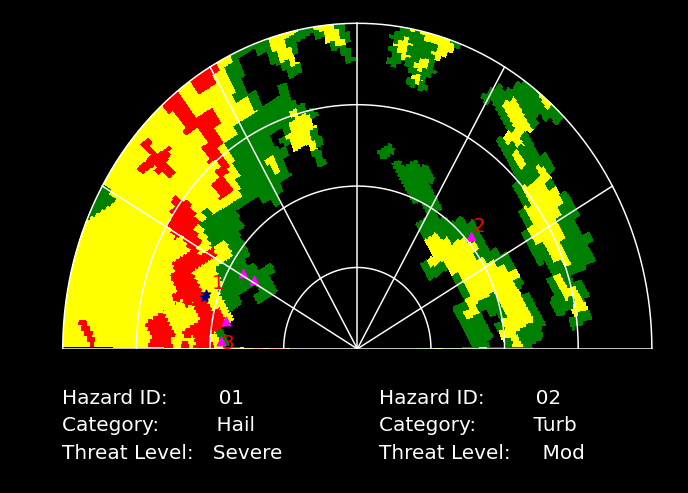

In [ ]:
fig = plt.figure(figsize=(10,9.5),facecolor='black')
#fig, ax = plt.subplots()
#assert isinstance(ax, matplotlibs.axes._axes.Axes)
#否则会画出很多蓝色
dbz_ac = np.where(dbz_ac == 0.0, np.nan , dbz_ac)
levels = MaxNLocator(nbins=13).tick_values(vmin, vmax)
ticks = levels
#pc = ax.pcolormesh( longtitude, latitude, dbz_ac,zorder=0, shading='auto') #,cmap='plasma'
#ax1 = fig.add_subplot(2,1,1)
ax1 = fig.add_axes([0.1, 0.3, 0.9, 0.5],facecolor='black') # [left, bottom, width, height]  ,facecolor='black'
X1,Y1 = rotate(radarX, radarY, heading_angle) # rotate should be clockwise --> *-1


hq_colors = ['Green', 'Yellow', 'Red']
cmap_hq = colors.ListedColormap(hq_colors)
add_ring(ax1, 0,np.pi, [0, 50, 100, 150, 200], color='white', linestyle='-', linewidth=1.5)

pc = ax1.pcolormesh( X1/1000, Y1/1000, dbz_ac, shading='auto', vmin = vmin, vmax = 50, cmap=cmap_hq ) #zorder=0,  dbz_ac是跟着转的，因为某个点对应的X1，Y1和dbz_ac是固定的

hail_index = np.argwhere(hid_ac == 9)
#hail_index = np.concatenate( (np.argwhere(hid_ac == 9) ,  np.argwhere(hid_ac == 8)) )
turb_index = np.argwhere(turb_ac > 0.7) 

pc1 = ax1.scatter(X1[hail_index[:,0],hail_index[:,1]]/1000, Y1[hail_index[:,0],hail_index[:,1]]/1000, marker = '*', color = 'navy', s=80)


for i in range(len(X1[hail_index[::5,0],hail_index[::5,1]])):
    plt.text(X1[hail_index[i,0],hail_index[i,1]]/1000+5, Y1[hail_index[i,0],hail_index[i,1]]/1000+5, str(i+1), color = 'red', fontsize=20)

#pc1 = ax1.pcolormesh( X1/1000, Y1/1000, hid_ac, vmin = 0, vmax = 10, cmap=cmaphid )
aii = 3
pc1 = ax1.scatter( X1[turb_index[::aii,0],turb_index[::aii,1]]/1000, Y1[turb_index[::aii,0],turb_index[::aii,1]]/1000, marker = '^', color = 'magenta', s=80)


indexx = 2
for i in range(len(X1[turb_index[::aii,0],turb_index[::aii,1]])):
    if X1[turb_index[i+1,0],turb_index[i+1,1]] - X1[turb_index[i,0],turb_index[i,1]] < 1000:
        continue
    plt.text(X1[turb_index[i,0],turb_index[i,1]]/1000+np.random.randint(-5,10), Y1[turb_index[i,0],turb_index[i,1]]/1000+np.random.randint(-10,10), str(indexx), color = 'red', fontsize=20)
    indexx = indexx +1

    


#pc2 =  ax1.contour(
#             X1/1000, Y1/1000, turb_ac, vmin=0.4, vmax=0.8, levels=np.array([0.6,0.8]), colors = 'black') #cmap='YlOrRd')  #, levels=np.array([0.4,0.6,0.8]

#ax1.contourf(X1/1000, Y1/1000, PyartRadar.fields['turbulence']['data'], vmin=0.4, vmax=0.8) [sweep_slice]

#ax1.text()
#plot_xy(ax1, radarX, radarY, dbz_ac) ##画图显示
#ax1.set_title('transformed airborne radar display', fontsize=20, color = 'white')
ax1.set_xlabel("Distance From Radar In East (km)", fontsize=10)
#ax1.set_ylabel("Distance From Radar In North (km)", fontsize=16)

#cb1 = fig.colorbar(mappable=pc, ax=ax1, orientation="vertical", pad = 0.01)

#cb1.ax.tick_params(color='white', labelcolor='white')
#cb.set_ticks(ticks)

ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2])
#ax2.text(0.05, 0.6, "CAPE       %s joule/kilogram"%str(cape)[0:6],fontsize=20, color = 'white') #x, y, s. x, y: The position to place the text. 
#ax2.text(0.05, 0.4, "CIN         %s joule/kilogram"%str(cin)[0:7],fontsize=20, color = 'white')
ax2.text(0.05, 0.6, "Hazard ID:        01",fontsize=20, color = 'white') #x, y, s. x, y: The position to place the text. 
ax2.text(0.05, 0.4, "Category:         Hail",fontsize=20, color = 'white')
ax2.text(0.05, 0.2, "Threat Level:   Severe",fontsize=20, color = 'white') 

ax2.text(0.6, 0.6, "Hazard ID:        02",fontsize=20, color = 'white') #x, y, s. x, y: The position to place the text. 
ax2.text(0.6, 0.4, "Category:         Turb",fontsize=20, color = 'white')
ax2.text(0.6, 0.2, "Threat Level:     Mod",fontsize=20, color = 'white') 


#ax2.text(0.05, 0.2, "Max Turb %s EDR^0.33"%str(np.nanmax(turb_ac))[0:4],fontsize=20, color = 'white') 

#plt.show()
plt.axis('off')
plt.savefig('tr_black.png')

1.1344640137963142
3.5779249665883754


c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\ProgramData\Anaconda3\lib\site-packages\pycwr\draw\RadarPlot.py:673: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  gci = ax.pcolormesh(x / 1000., y / 1000., data, cmap=cmaps, \


Text(0.5, 1.0, 'Composite Reflectivity (dBZ)')

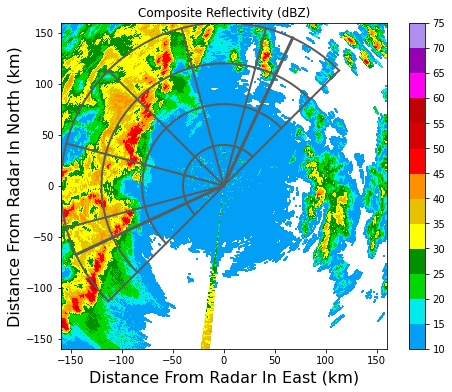

In [ ]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
    
#CompRef = np.where( (i**2+y1d**2<160000**2),PRD.product['CR'],np.nan)
plot_xy(ax1, grid_x, grid_y, PRD.product['CR'],bounds=np.arange(10, 76, 5),cmap=icmap) ##画图显示 
add_ring(ax1, np.deg2rad(135-90),np.deg2rad(135+90), [0, 40, 80, 120, 160], linestyle='-', linewidth=2)
add_line_air(ax1, 135,70, [0, 40, 80, 120, 160], linestyle='-', linewidth=2)
ax1.set_xlabel("Distance From Radar In East (km)", fontsize=16)
ax1.set_ylabel("Distance From Radar In North (km)", fontsize=16)
ax1.set_title("Composite Reflectivity (dBZ)") #  at %s" %)


c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


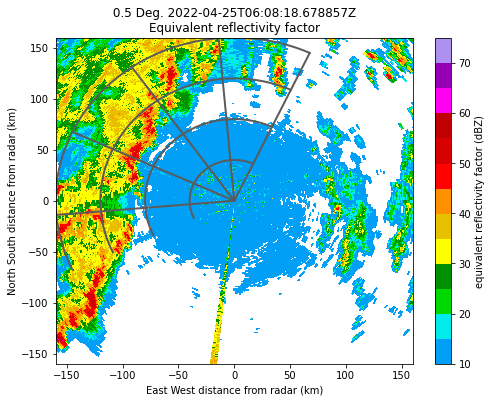

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
display = pyart.graph.RadarDisplay(PyartRadar)

display.plot('reflectivity', vmin=10, vmax=75,cmap=icmap) #, cmap='pyart_NWSRef')
display.set_limits(xlim=[-160,160], ylim=[-160,160])
add_ring(ax, np.deg2rad(135-70),np.deg2rad(135+70), [0, 40, 80, 120, 160], linestyle='-', linewidth=2)
plt.savefig('verify_0.5degree.png')

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12.0, 9.0]
PyartRadar.info('standard')
# try out 'standard' or 'full' also

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (3261,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float64 and shape: (3261,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	velocity:
		data: <ndarray of type: float64 and shape: (3261, 1320)>
		units: meters_per_second
		standard_name: radial_velocity_of_scatterers_away_from_instrument
		long_name: Mean dopper velocity
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	spectrum_width:
		data: <ndarray of type: floa

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


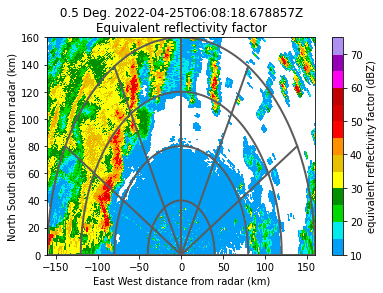

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
display = pyart.graph.RadarDisplay(PyartRadar)
display.plot('reflectivity', vmin=10, vmax=75,cmap=icmap) #, cmap='pyart_NWSRef')
display.set_limits(xlim=[-160,160], ylim=[0,160])
add_ring(ax, 0,np.pi, [0, 40, 80, 120, 160], linestyle='-', linewidth=2)

In [ ]:
type(PyartRadar.elevation)

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict

In [ ]:
PyartRadar.elevation.keys()

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['units', 'standard_name', 'long_name', 'axis', 'comment', 'data'])

In [ ]:
PyartRadar.elevation['data']

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 0.5       ,  0.5       ,  0.5       , ..., 19.53000069,
       19.53000069, 19.53000069])

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


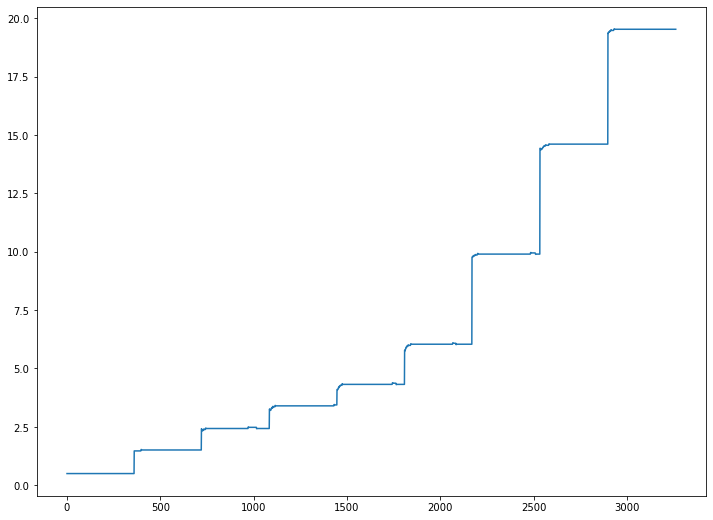

In [ ]:
plt.plot(PyartRadar.elevation['data'])
#plt.plot(PyartRadar.azimuth['data'])

In [ ]:
PyartRadar.nsweeps

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


9

In [ ]:
PyartRadar.instrument_parameters.keys()

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['pulse_width', 'radar_beam_width_h', 'radar_beam_width_v', 'frequency', 'nyquist_velocity'])

In [ ]:
display = pyart.graph.RadarMapDisplay(PyartRadar)

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\ProgramData\Anaconda3\lib\site-packages\pyart\graph\radarmapdisplay.py:256: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes.
  warnings.warn("No projection was defined for the axes."
c:\ProgramData\Anaconda3\lib\site-packages\pyart\graph\radarmapdisplay.py:507: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.get_path().vertices.tolist())
c:\ProgramData\Anaconda3\lib\site-packages\pyart\graph\radarmapdisplay.py:507: DeprecationWarning: The outline_patch property is deprecated. Use Ge

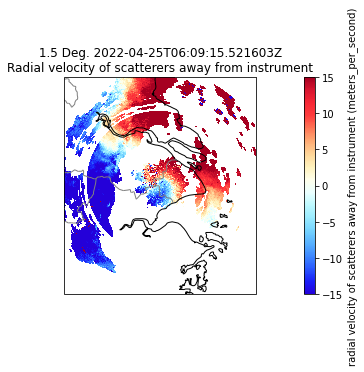

In [ ]:
display = pyart.graph.RadarMapDisplay(PyartRadar)
f = plt.figure(figsize = [17,4])
plt.subplot(1, 3, 1) 
display.plot_ppi_map('differential_reflectivity', max_lat = 33, min_lat =29, min_lon = 123., max_lon = 119,
                     vmin = -7, vmax = 7, lat_lines = np.arange(20,28,.2), lon_lines = np.arange(-82, -79, .5),
                     resolution = '10m')
plt.subplot(1, 3, 2) 
display.plot_ppi_map('reflectivity', max_lat = 33, min_lat =29, min_lon = 123., max_lon = 119,
                     vmin = -8, vmax = 64, lat_lines = np.arange(20,28,.2), lon_lines = np.arange(-82, -79, .5),
                     resolution = '10m')
plt.subplot(1, 3, 3) 
display.plot_ppi_map('velocity', sweep = 1, max_lat = 33, min_lat =29, min_lon = 123., max_lon = 119,
                     vmin = -15, vmax = 15, lat_lines = np.arange(20,28,.2), lon_lines = np.arange(-82, -79, .5),
                     resolution = '10m')


In [ ]:
np.__file__

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'c:\\ProgramData\\Anaconda3\\lib\\site-packages\\numpy\\__init__.py'

In [ ]:
print(PyartRadar.fields['velocity']['coordinates'])

elevation azimuth range


c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
